In [5]:
import warnings
warnings.filterwarnings('ignore')

# For interactive data visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import yfinance as yf
import hvplot.pandas
from pathlib import Path
import requests
import json
import csv
import io
from finta import TA
import matplotlib.pyplot as plt

import datetime as dt
#import cufflinks as cf
#import quantstats as qs
import math
from math import floor
#from termcolor import colored as cl
import requests
#import pyfolio as pf

In [6]:
### Quant framework 3 x 3 x 3

#     Intraday   >>Swing<<    >>Position<<

#     Earnings     Event      >>TA<<

#   >>Delta<<      Theta        Vega

# Project 2 scope is focused on Swing and Position timeframe, while relying on TA
# to determine signals. Option strategies are not used.

### Technical goal:

# Automate creation and testing of new trading algorithms based on our framework

### Plan:

# 1. Pull the data: ohlc + volume ✓
# 2. Integrate Finta with our data ✓
# 3. Determine trading signals for testable indicators (crossovers, etc.)
# 4. Test the strategy on data of 2017 - 2020 
# 5. Automate testing of different combinations of strategies
# 6. Train ML algorithms on best performing strategies
# 7. Deploy trained ML algorithms and test performance on 2021-2023 data

In [7]:
alpha_vantage_key = 'N35DJ1POAUO7MXX6'
trading_days_year = 252
total_days_year = 365
#thirty_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 30)).date()
#ten_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 10)).date()
#five_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 5)).date()
three_years_ago = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 3)).date()
one_year = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year * 1)).date()
six_months = (pd.Timestamp.today() - pd.Timedelta(days = total_days_year / 2)).date()
yesterday = (pd.Timestamp.today() - pd.Timedelta(days = 1)).date()

url = f'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey={alpha_vantage_key}'
response = requests.get(url)
data = response.text

# 1. Pull the data: ohlc + volume

In [8]:
listed_stocks = pd.read_csv(io.StringIO(data))
listed_stocks = listed_stocks[listed_stocks['exchange'] == 'NASDAQ']
listed_stocks = listed_stocks[listed_stocks['symbol'].str.len() <= 4]
listed_stocks = listed_stocks[listed_stocks['ipoDate'] <= '2017-01-01']
listed_stocks

,symbol,name,exchange,assetType,ipoDate,delistingDate,status
7,AACG,ATA Creativity Global,NASDAQ,Stock,2008-01-29,NaN,Active
15,AADR,AdvisorShares Dorsey Wright ADR ETF,NASDAQ,ETF,2010-07-21,NaN,Active
20,AAL,American Airlines Group Inc,NASDAQ,Stock,2005-09-27,NaN,Active
22,AAME,Atlantic American Corp,NASDAQ,Stock,1984-09-07,NaN,Active
24,AAOI,Applied Optoelectronics Inc,NASDAQ,Stock,2013-09-26,NaN,Active
...,...,...,...,...,...,...,...
11539,ZUMZ,Zumiez Inc,NASDAQ,Stock,2005-05-06,NaN,Active
11544,ZVRA,Zevra Therapeutics Inc,NASDAQ,Stock,2015-04-16,NaN,Active
11553,ZYNE,Zynerba Pharmaceuticals Inc,NASDAQ,Stock,2015-08-05,NaN,Active
11554,ZYRX,Global Earnings Capital Ltd,NASDAQ,Stock,2007-07-13,NaN,Active


In [9]:
symbols = listed_stocks['symbol']
symbols_str = symbols.to_list()
yf_df = yf.Tickers(symbols_str)
df_full =yf_df.history(start = '2017-01-01', end = yesterday)

[*********************100%***********************]  2132 of 2132 completed

ERROR 
4 Failed downloads:
ERROR ['AGTC']: Exception('AGTC: No timezone found, symbol may be delisted')
ERROR ['RNWK']: Exception('RNWK: No timezone found, symbol may be delisted')
ERROR ['ZYRX']: Exception('ZYRX: No timezone found, symbol may be delisted')
ERROR ['AGFS']: Exception('AGFS: No data found, symbol may be delisted')


In [10]:
df = df_full[['Open', 'Close', 'High', 'Low', 'Volume']]
df.head()

Open                                             \
                         AACG       AADR        AAL      AAME       AAOI   
Date                                                                       
2017-01-03 00:00:00  0.365409  38.225504  45.688244  3.930859  23.709999   
2017-01-04 00:00:00  0.372123  39.027700  45.060123  4.027917  23.129999   
2017-01-05 00:00:00  0.366368  39.634012  44.953823  4.047329  23.500000   
2017-01-06 00:00:00  0.381713  39.307543  44.306374  3.979388  22.990000   
2017-01-09 00:00:00  0.351023  39.717963  44.460992  4.076446  22.360001   

                                                                      ...  \
                          AAON       AAPL       AAXJ       ABCB ABCM  ...   
Date                                                                  ...   
2017-01-03 00:00:00  32.015933  27.014197  49.426854  40.412987  NaN  ...   
2017-01-04 00:00:00  32.015931  27.025864  49.694223  40.092596  NaN  ...   
2017-01-05 00:00:00  32.590203  27.042191  50.425033  40.687583  NaN  ...   
2017-01-06 00:00:00  31.728794  27.242815  50.425026  40.596049  NaN  ...   
2017-01-09 00:00:00  31.106661  27.515758  50.362645  39.863763  NaN  ...   

                     Volume                                              \
                       ZEUS      ZG     ZION   ZIVO  ZTEK    ZUMZ  ZVRA   
Date                                                                      
2017-01-03 00:00:00  148800  640200  2896200  23300  5400  679600  6638   
2017-01-04 00:00:00  107700  453000  1907500  22600     0  559500  8131   
2017-01-05 00:00:00  116900  466000  2106000  43000     0  826200  2606   
2017-01-06 00:00:00  126800  438900  2149100   2000     0  455400   825   
2017-01-09 00:00:00  175600  377500  2104900  20000     0  536300  3525   

                                         
                       ZYNE ZYRX   ZYXI  
Date                                     
2017-01-03 00:00:00  409800  NaN   2530  
2017-01-04 00:00:00  578500  NaN      0  
2017-01-05 00:00:00  436300  NaN   1650  
2017-01-06 00:00:00  325700  NaN  13420  
2017-01-09 00:00:00  212900  NaN  31680  

[5 rows x 10660 columns]

In [11]:
# Create start and end date variables
start_date = dt.date(2017, 1, 1)
end_date = dt.date(2020, 12, 31) # Including 2020-4-30 data in sample 

# Print start and end dates
print('Start date is', start_date)
print('End date is', end_date)

# Using the yfinance library, get MSFT data for analysis time period
ticker = ['MSFT']  # the scrip for which we want the data

# Use all adjusted close data only for analysis
df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)

Start date is 2017-01-01
End date is 2020-12-31
[*********************100%***********************]  1 of 1 completed


In [12]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,58.599553,58.646215,57.983599,58.403568,20694100
2017-01-04,58.310230,58.562211,57.974255,58.142242,21340000
2017-01-05,58.039583,58.478217,57.890261,58.142242,24876000
2017-01-06,58.142247,58.935522,57.899601,58.646210,19922900
2017-01-09,58.571547,58.870194,58.366232,58.459557,20382700
...,...,...,...,...,...
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500


# 2. Integrate Finta with our data 

In [13]:
### List of indicators we will use:


# 1.  EMA
# 2.  VWAP
# 3.  SQZMI
# 4.  MACD
# 5.  ADX
# 6.  BBANDS
# 7.  ICHIMOKU
# 8.  MFI
# 9.  CHAIKIN
# 10. RSI
# 11. STOCH
# 12. STOCHD
# 13. PIVOT
# 14. PIVOT_FIB


In [14]:
TA.EMA?

Signature:
TA.EMA(
    ohlc: pandas.core.frame.DataFrame,
    period: int = 9,
    column: str = 'close',
    adjust: bool = True,
) -> pandas.core.series.Series
Docstring:
Exponential Weighted Moving Average - Like all moving average indicators, they are much better suited for trending markets.
When the market is in a strong and sustained uptrend, the EMA indicator line will also show an uptrend and vice-versa for a down trend.
EMAs are commonly used in conjunction with other indicators to confirm significant market moves and to gauge their validity.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [15]:
TA.VWAP?

Signature: TA.VWAP(ohlcv: pandas.core.frame.DataFrame) -> pandas.core.series.Series
Docstring:
The volume weighted average price (VWAP) is a trading benchmark used especially in pension plans.
VWAP is calculated by adding up the dollars traded for every transaction (price multiplied by number of shares traded) and then dividing
by the total shares traded for the day.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [16]:
TA.SQZMI?

Signature:
TA.SQZMI(
    ohlc: pandas.core.frame.DataFrame,
    period: int = 20,
    MA: pandas.core.series.Series = None,
) -> pandas.core.frame.DataFrame
Docstring:
Squeeze Momentum Indicator

The Squeeze indicator attempts to identify periods of consolidation in a market.
In general the market is either in a period of quiet consolidation or vertical price discovery.
By identifying these calm periods, we have a better opportunity of getting into trades with the potential for larger moves.
Once a market enters into a “squeeze”, we watch the overall market momentum to help forecast the market direction and await a release of market energy.

:param pd.DataFrame ohlc: 'open, high, low, close' pandas DataFrame
:period: int - number of periods to take into consideration
:MA pd.Series: override internal calculation which uses SMA with moving average of your choice
:return pd.Series: indicator calcs as pandas Series

SQZMI['SQZ'] is bool True/False, if True squeeze is on. If false, squeeeze

In [17]:
TA.MACD?

Signature:
TA.MACD(
    ohlc: pandas.core.frame.DataFrame,
    period_fast: int = 12,
    period_slow: int = 26,
    signal: int = 9,
    column: str = 'close',
    adjust: bool = True,
) -> pandas.core.frame.DataFrame
Docstring:
MACD, MACD Signal and MACD difference.
The MACD Line oscillates above and below the zero line, which is also known as the centerline.
These crossovers signal that the 12-day EMA has crossed the 26-day EMA. The direction, of course, depends on the direction of the moving average cross.
Positive MACD indicates that the 12-day EMA is above the 26-day EMA. Positive values increase as the shorter EMA diverges further from the longer EMA.
This means upside momentum is increasing. Negative MACD values indicates that the 12-day EMA is below the 26-day EMA.
Negative values increase as the shorter EMA diverges further below the longer EMA. This means downside momentum is increasing.

Signal line crossovers are the most common MACD signals. The signal line is a 9-day EMA

In [18]:
TA.ADX?

Signature:
TA.ADX(
    ohlc: pandas.core.frame.DataFrame,
    period: int = 14,
    adjust: bool = True,
) -> pandas.core.series.Series
Docstring:
The A.D.X. is 100 * smoothed moving average of absolute value (DMI +/-) divided by (DMI+ + DMI-). ADX does not indicate trend direction or momentum,
only trend strength. Generally, A.D.X. readings below 20 indicate trend weakness,
and readings above 40 indicate trend strength. An extremely strong trend is indicated by readings above 50
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [19]:
TA.BBANDS?

Signature:
TA.BBANDS(
    ohlc: pandas.core.frame.DataFrame,
    period: int = 20,
    MA: pandas.core.series.Series = None,
    column: str = 'close',
    std_multiplier: float = 2,
) -> pandas.core.frame.DataFrame
Docstring:
Developed by John Bollinger, Bollinger Bands® are volatility bands placed above and below a moving average.
Volatility is based on the standard deviation, which changes as volatility increases and decreases.
The bands automatically widen when volatility increases and narrow when volatility decreases.

This method allows input of some other form of moving average like EMA or KAMA around which BBAND will be formed.
Pass desired moving average as <MA> argument. For example BBANDS(MA=TA.KAMA(20)).
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [20]:
TA.ICHIMOKU?

Signature:
TA.ICHIMOKU(
    ohlc: pandas.core.frame.DataFrame,
    tenkan_period: int = 9,
    kijun_period: int = 26,
    senkou_period: int = 52,
    chikou_period: int = 26,
) -> pandas.core.frame.DataFrame
Docstring:
The Ichimoku Cloud, also known as Ichimoku Kinko Hyo, is a versatile indicator that defines support and resistance,
identifies trend direction, gauges momentum and provides trading signals.

Ichimoku Kinko Hyo translates into “one look equilibrium chart”.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [21]:
TA.MFI?

Signature: TA.MFI(ohlc: pandas.core.frame.DataFrame, period: int = 14) -> pandas.core.series.Series
Docstring:
The money flow index (MFI) is a momentum indicator that measures
the inflow and outflow of money into a security over a specific period of time.
MFI can be understood as RSI adjusted for volume.
The money flow indicator is one of the more reliable indicators of overbought and oversold conditions, perhaps partly because
it uses the higher readings of 80 and 20 as compared to the RSI's overbought/oversold readings of 70 and 30
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [22]:
TA.CHAIKIN?

Signature: TA.CHAIKIN(ohlcv: pandas.core.frame.DataFrame, adjust: bool = True) -> pandas.core.series.Series
Docstring:
Chaikin Oscillator, named after its creator, Marc Chaikin, the Chaikin oscillator is an oscillator that measures the accumulation/distribution
line of the moving average convergence divergence (MACD). The Chaikin oscillator is calculated by subtracting a 10-day exponential moving average (EMA)
of the accumulation/distribution line from a three-day EMA of the accumulation/distribution line, and highlights the momentum implied by the
accumulation/distribution line.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [23]:
TA.RSI?

Signature:
TA.RSI(
    ohlc: pandas.core.frame.DataFrame,
    period: int = 14,
    column: str = 'close',
    adjust: bool = True,
) -> pandas.core.series.Series
Docstring:
Relative Strength Index (RSI) is a momentum oscillator that measures the speed and change of price movements.
RSI oscillates between zero and 100. Traditionally, and according to Wilder, RSI is considered overbought when above 70 and oversold when below 30.
Signals can also be generated by looking for divergences, failure swings and centerline crossovers.
RSI can also be used to identify the general trend.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [24]:
TA.STOCH?

Signature: TA.STOCH(ohlc: pandas.core.frame.DataFrame, period: int = 14) -> pandas.core.series.Series
Docstring:
Stochastic oscillator %K
The stochastic oscillator is a momentum indicator comparing the closing price of a security
to the range of its prices over a certain period of time.
The sensitivity of the oscillator to market movements is reducible by adjusting that time
period or by taking a moving average of the result.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [25]:
TA.STOCHD?

Signature:
TA.STOCHD(
    ohlc: pandas.core.frame.DataFrame,
    period: int = 3,
    stoch_period: int = 14,
) -> pandas.core.series.Series
Docstring:
Stochastic oscillator %D
STOCH%D is a 3 period simple moving average of %K.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [26]:
TA.PIVOT?

Signature: TA.PIVOT(ohlc: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame
Docstring:
Pivot Points are significant support and resistance levels that can be used to determine potential trades.
The pivot points come as a technical analysis indicator calculated using a financial instrument’s high, low, and close value.
The pivot point’s parameters are usually taken from the previous day’s trading range.
This means you’ll have to use the previous day’s range for today’s pivot points.
Or, last week’s range if you want to calculate weekly pivot points or, last month’s range for monthly pivot points and so on.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [27]:
TA.PIVOT_FIB?

Signature: TA.PIVOT_FIB(ohlc: pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame
Docstring:
Fibonacci pivot point levels are determined by first calculating the classic pivot point,
then multiply the previous day’s range with its corresponding Fibonacci level.
Most traders use the 38.2%, 61.8% and 100% retracements in their calculations.
File:      c:\users\horizon\anaconda3\envs\algotrading\lib\site-packages\finta\finta.py
Type:      function

In [28]:
def get_individual_stock(stock, df = df):
    mask = yf_df_ohlc.columns.get_level_values(1) == stock
    data = yf_df_ohlc.loc[:, mask]
    data.columns = data.columns.droplevel(1)
    return data

## Getting indicators demo
### Once we have the finalized list of indicators, I will combine them into one function

In [29]:
# EMA
#tsla = get_individual_stock('TSLA')
df['EMA_50'] = TA.EMA(df, 50).head()
df.head()

,Open,High,Low,Close,Volume,EMA_50
Date,,,,,,
2017-01-03,58.599553,58.646215,57.983599,58.403568,20694100,58.403568
2017-01-04,58.310230,58.562211,57.974255,58.142242,21340000,58.270292
2017-01-05,58.039583,58.478217,57.890261,58.142242,24876000,58.225890
2017-01-06,58.142247,58.935522,57.899601,58.646210,19922900,58.337357
2017-01-09,58.571547,58.870194,58.366232,58.459557,20382700,58.363791


In [30]:
# VWAP
#tsla = get_individual_stock('TSLA')
df['VWAP'] = TA.VWAP(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP
Date,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959


In [31]:
# SQUEEZE
#tsla = get_individual_stock('TSLA')
df['SQZ'] = TA.SQZMI(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ
Date,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False


In [32]:
# MACD
#tsla = get_individual_stock('TSLA')
df[['MACD', 'SIGNAL']] = TA.MACD(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL
Date,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202


In [33]:
# ADX
#tsla = get_individual_stock('TSLA')
df['ADX'] = TA.ADX(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,ADX
Date,,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,12.992040
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,13.990001
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,15.437720
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539,17.012230
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202,17.597599


In [34]:
# BBANDS
#tsla = get_individual_stock('TSLA')
df[['BB_UPPER','BB_MIDDLE','BB_LOWER']] = TA.BBANDS(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,ADX,BB_UPPER,BB_MIDDLE,BB_LOWER
Date,,,,,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,12.992040,222.209056,215.126634,208.044213
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,13.990001,223.148269,215.568594,207.988919
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,15.437720,224.466971,216.052858,207.638745
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539,17.012230,225.408825,216.554540,207.700256
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202,17.597599,225.841185,216.826782,207.812380


In [35]:
# ICHIMOKU
#tsla = get_individual_stock('TSLA')
df2 = TA.ICHIMOKU(df)
df2.tail()

,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU
Date,,,,,
2020-12-23,216.370888,215.898074,214.837904,211.248930,NaN
2020-12-24,217.928705,215.898074,214.837904,210.658195,NaN
2020-12-28,218.127777,216.097146,214.837904,210.658195,NaN
2020-12-29,219.934432,216.669507,214.837904,210.658195,NaN
2020-12-30,220.581447,216.669507,212.601617,210.658195,NaN


In [36]:
# MFI
#tsla = get_individual_stock('TSLA')
df['MFI']  = TA.MFI(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,ADX,BB_UPPER,BB_MIDDLE,BB_LOWER,MFI
Date,,,,,,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,12.992040,222.209056,215.126634,208.044213,49.437738
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,13.990001,223.148269,215.568594,207.988919,53.673224
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,15.437720,224.466971,216.052858,207.638745,58.982894
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539,17.012230,225.408825,216.554540,207.700256,58.467745
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202,17.597599,225.841185,216.826782,207.812380,60.106469


In [37]:
# CHAIKIN
#tsla = get_individual_stock('TSLA')
df['CHAI'] = TA.CHAIKIN(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,ADX,BB_UPPER,BB_MIDDLE,BB_LOWER,MFI,CHAI
Date,,,,,,,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,12.992040,222.209056,215.126634,208.044213,49.437738,2.378796e+07
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,13.990001,223.148269,215.568594,207.988919,53.673224,1.961445e+07
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,15.437720,224.466971,216.052858,207.638745,58.982894,1.777327e+07
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539,17.012230,225.408825,216.554540,207.700256,58.467745,1.162041e+07
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202,17.597599,225.841185,216.826782,207.812380,60.106469,2.247854e+06


In [38]:
# RSI
#tsla = get_individual_stock('TSLA')
df['RSI'] = TA.RSI(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,ADX,BB_UPPER,BB_MIDDLE,BB_LOWER,MFI,CHAI,RSI
Date,,,,,,,,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,12.992040,222.209056,215.126634,208.044213,49.437738,2.378796e+07,58.942916
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,13.990001,223.148269,215.568594,207.988919,53.673224,1.961445e+07,61.414067
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,15.437720,224.466971,216.052858,207.638745,58.982894,1.777327e+07,64.364709
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539,17.012230,225.408825,216.554540,207.700256,58.467745,1.162041e+07,62.478892
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202,17.597599,225.841185,216.826782,207.812380,60.106469,2.247854e+06,56.995026


In [39]:
# STOCH
#tsla = get_individual_stock('TSLA')
df['STOCH'] = TA.STOCH(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,ADX,BB_UPPER,BB_MIDDLE,BB_LOWER,MFI,CHAI,RSI,STOCH
Date,,,,,,,,,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,12.992040,222.209056,215.126634,208.044213,49.437738,2.378796e+07,58.942916,72.094383
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,13.990001,223.148269,215.568594,207.988919,53.673224,1.961445e+07,61.414067,82.566613
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,15.437720,224.466971,216.052858,207.638745,58.982894,1.777327e+07,64.364709,93.676166
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539,17.012230,225.408825,216.554540,207.700256,58.467745,1.162041e+07,62.478892,83.231880
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202,17.597599,225.841185,216.826782,207.812380,60.106469,2.247854e+06,56.995026,69.562804


In [40]:
# STOCHD
#tsla = get_individual_stock('TSLA')
df['STOCHD'] = TA.STOCHD(df)
df.tail()

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,ADX,BB_UPPER,BB_MIDDLE,BB_LOWER,MFI,CHAI,RSI,STOCH,STOCHD
Date,,,,,,,,,,,,,,,,,,,
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,12.992040,222.209056,215.126634,208.044213,49.437738,2.378796e+07,58.942916,72.094383,84.131628
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,13.990001,223.148269,215.568594,207.988919,53.673224,1.961445e+07,61.414067,82.566613,81.476987
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,15.437720,224.466971,216.052858,207.638745,58.982894,1.777327e+07,64.364709,93.676166,82.779054
2020-12-29,225.269796,226.135792,222.552348,223.119720,17403200,NaN,126.194654,False,2.736602,1.894539,17.012230,225.408825,216.554540,207.700256,58.467745,1.162041e+07,62.478892,83.231880,86.491553
2020-12-30,224.194758,224.592928,220.452046,220.661072,20272300,NaN,126.260959,False,2.617854,2.039202,17.597599,225.841185,216.826782,207.812380,60.106469,2.247854e+06,56.995026,69.562804,82.156950


In [41]:
# PIVOT
#tsla = get_individual_stock('TSLA')
#df['PIVOT'] = TA.PIVOT(df)
df3 = TA.PIVOT(df)
df3.tail()

,pivot,s1,s2,s3,s4,r1,r2,r3,r4
Date,,,,,,,,,
2020-12-23,222.777972,220.963019,219.015347,217.200394,215.385441,224.725643,226.540596,228.488268,230.435939
2020-12-24,220.773881,219.015338,218.026572,216.268030,214.509488,221.762647,223.521189,224.509955,225.498721
2020-12-28,221.497222,220.412231,219.098296,218.013304,216.928313,222.811157,223.896149,225.210084,226.524019
2020-12-29,223.637324,222.283580,220.641165,219.287421,217.933676,225.279739,226.633484,228.275899,229.918313
2020-12-30,223.935954,221.736115,220.352510,218.152671,215.952832,225.319559,227.519398,228.903003,230.286608


In [42]:
# PIVOT_FIB
#tsla = get_individual_stock('TSLA')
df4 = TA.PIVOT_FIB(df)
df4.tail()

columns = ["Pivot", "fs1", "fs2", "fs3", "fs4", "fr1", "fr2", "fr3","fr4"]
df4.columns = columns
df4 = df4.drop(columns=["Pivot"])
df4.tail()

,pivot,s1,s2,s3,s4,r1,r2,r3,r4
Date,,,,,,,,,
2020-12-23,222.777972,221.340649,220.452670,219.015347,217.578025,224.215294,225.103274,226.540596,227.977919
2020-12-24,220.773881,219.724409,219.076044,218.026572,216.977101,221.823353,222.471717,223.521189,224.570661
2020-12-28,221.497222,220.580832,220.014686,219.098296,218.181906,222.413612,222.979759,223.896149,224.812539
2020-12-29,223.637324,222.492792,221.785698,220.641165,219.496632,224.781857,225.488951,226.633484,227.778017
2020-12-30,223.935954,222.567078,221.721385,220.352510,218.983634,225.304829,226.150522,227.519398,228.888273


,fs1,fs2,fs3,fs4,fr1,fr2,fr3,fr4
Date,,,,,,,,
2020-12-23,221.340649,220.452670,219.015347,217.578025,224.215294,225.103274,226.540596,227.977919
2020-12-24,219.724409,219.076044,218.026572,216.977101,221.823353,222.471717,223.521189,224.570661
2020-12-28,220.580832,220.014686,219.098296,218.181906,222.413612,222.979759,223.896149,224.812539
2020-12-29,222.492792,221.785698,220.641165,219.496632,224.781857,225.488951,226.633484,227.778017
2020-12-30,222.567078,221.721385,220.352510,218.983634,225.304829,226.150522,227.519398,228.888273


In [43]:
df5 = pd.DataFrame()

df5 = pd.concat([df,df2,df3,df4], axis="columns", join="inner")

my_list = df5.columns.values.tolist()

my_list

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'EMA_50',
 'VWAP',
 'SQZ',
 'MACD',
 'SIGNAL',
 'ADX',
 'BB_UPPER',
 'BB_MIDDLE',
 'BB_LOWER',
 'MFI',
 'CHAI',
 'RSI',
 'STOCH',
 'STOCHD',
 'TENKAN',
 'KIJUN',
 'senkou_span_a',
 'SENKOU',
 'CHIKOU',
 'pivot',
 's1',
 's2',
 's3',
 's4',
 'r1',
 'r2',
 'r3',
 'r4',
 'fs1',
 'fs2',
 'fs3',
 'fs4',
 'fr1',
 'fr2',
 'fr3',
 'fr4']

In [44]:
df = df5
df

,Open,High,Low,Close,Volume,EMA_50,VWAP,SQZ,MACD,SIGNAL,...,r3,r4,fs1,fs2,fs3,fs4,fr1,fr2,fr3,fr4
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,58.599553,58.646215,57.983599,58.403568,20694100,58.403568,58.344461,False,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,58.310230,58.562211,57.974255,58.142242,21340000,58.270292,58.284440,False,-0.005863,-0.003257,...,59.367938,59.728799,58.091342,57.934964,57.681845,57.428726,58.597580,58.753957,59.007076,59.260196
2017-01-05,58.039583,58.478217,57.890261,58.142242,24876000,58.225890,58.241983,False,-0.007471,-0.004984,...,59.066174,59.318155,58.001637,57.862879,57.638280,57.413681,58.450835,58.589593,58.814192,59.038792
2017-01-06,58.142247,58.935522,57.899601,58.646210,19922900,58.337357,58.299754,False,0.010177,0.000152,...,59.038176,59.318155,57.945641,57.806883,57.582284,57.357685,58.394840,58.533597,58.758197,58.982796
2017-01-09,58.571547,58.870194,58.366232,58.459557,20382700,58.363791,58.350242,False,0.012124,0.003713,...,60.123876,60.718053,58.098055,57.853578,57.457856,57.062134,58.889500,59.133977,59.529699,59.925422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,222.084494,222.532423,219.785115,220.004105,18699600,NaN,126.042098,False,2.113019,1.244083,...,228.488268,230.435939,221.340649,220.452670,219.015347,217.578025,224.215294,225.103274,226.540596,227.977919
2020-12-24,220.402277,222.582214,220.183287,221.726166,10550600,NaN,126.076580,False,2.301275,1.455521,...,224.509955,225.498721,219.724409,219.076044,218.026572,216.977101,221.823353,222.471717,223.521189,224.570661
2020-12-28,223.418329,224.991069,221.994910,223.925995,17933500,NaN,126.136449,False,2.598028,1.684023,...,225.210084,226.524019,220.580832,220.014686,219.098296,218.181906,222.413612,222.979759,223.896149,224.812539


# 3. Determine trading signals for testable indicators (crossovers, etc.)

In [45]:
# Define a class
class BacktestingCrossover:
    
    def __init__(self, ticker, start_date, end_date , ma_short, ma_long):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.ma_short = ma_short
        self.ma_long = ma_long
        
        # Call the basic methods in the __init__ constructor itself so that they are automatically executed 
        # upon object creation
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
        
    def fetch_data(self):
        self.df = yf.download(self.ticker, self.start_date, self.end_date)
        
    def indicators(self):
        self.df['ma_short'] = self.df['Close'].rolling(window= self.ma_short, center=False).mean()
        self.df['ma_long'] = self.df['Close'].rolling(window= self.ma_long, center=False).mean()
        self.df['ma_short_prev'] = self.df['ma_short'].shift()
        self.df['ma_long_prev'] = self.df['ma_long'].shift()
        self.df.dropna(inplace=True)
   
    def signals(self):
        self.df['signal'] = np.where((self.df['ma_short'] > self.df['ma_long']) 
                            & (self.df['ma_short_prev'] < self.df['ma_long_prev']), 1, 0)
        
        self.df['signal'] = np.where((self.df['ma_short'] < self.df['ma_long']) 
                            & (self.df['ma_short_prev'] > self.df['ma_long_prev']), -1, self.df['signal'])
    
    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace=0, method='ffill')
        
    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Adj Close'] / self.df['Adj Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        print('Total return:', np.round(self.df['strategy_returns'].cumsum()[-1], 2))
        return self.df['strategy_returns'].cumsum()[-1]
       
    def analysis(self):
        # A plot to check if the strategy is working as planned:
        self.df[['ma_short','ma_long', 'position']].plot(figsize=(15, 6), secondary_y='position', grid=True)
        plt.title('checking if positions are generated properly')
        plt.show()

        # A plot to check how the strategy performs relative to buy & hold
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize=(15, 6), secondary_y='position', grid=True)
        plt.title("Buy & hold' vs 'crossover strategy' cumulative returns")
        plt.show()

        # Generate analytics using the QuantStats library
        qs.reports.basic(self.df['strategy_returns'])

In [46]:
# Create start and end dates for the past 252 days
end_date = dt.datetime(2019,12,31).date()
start_date = dt.datetime(2017,1,1).date()

print('Start date:', start_date)
print('End date:', end_date)

Start date: 2017-01-01
End date: 2019-12-31


In [47]:

# Check the performance of this strategy in the broad-based index (Nifty 50) over the same timeframe
# when ma_short=10 and ma_long=20
msft_10_20 = BacktestingCrossover('MSFT', start_date, end_date, 5, 21)

[*********************100%***********************]  1 of 1 completed
Total return: -0.32


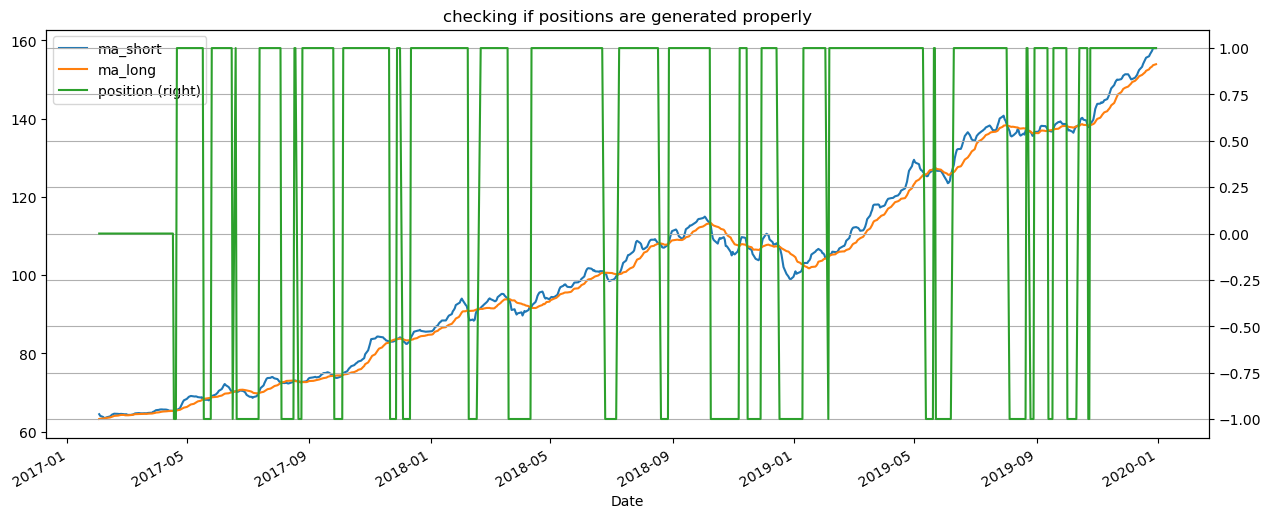

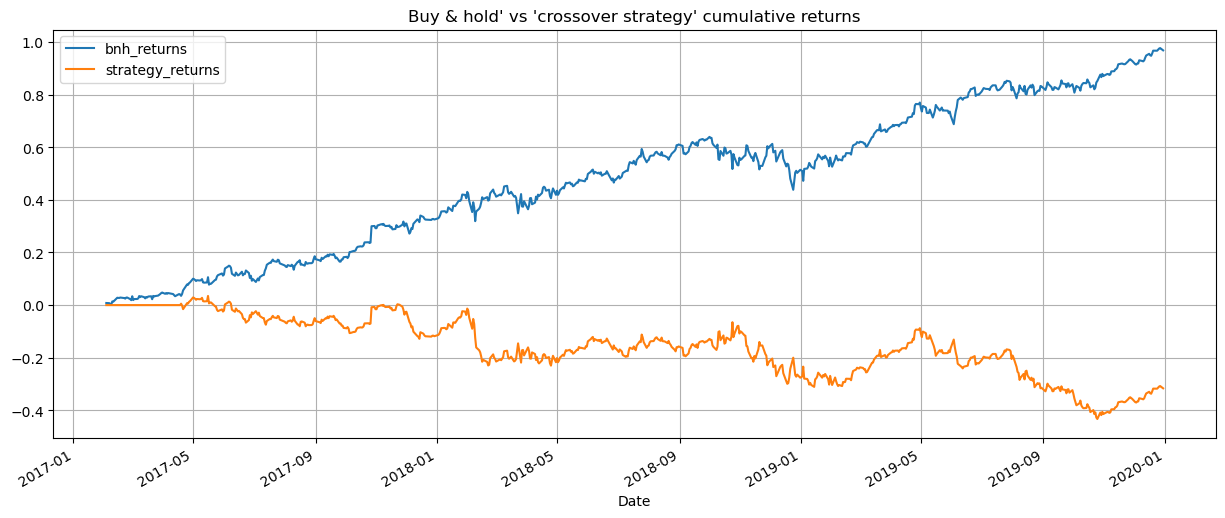

NameError: name 'qs' is not defined

In [48]:
# For additional analysis, we can always call the analysis() function for any instance
msft_10_20.analysis()

In [ ]:
# Define a class
class BacktestingSQZMACDCrossover:
    
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        #self.ma_short = ma_short
        #self.ma_long = ma_long
        
        # Call the basic methods in the __init__ constructor itself so that they are automatically executed 
        # upon object creation
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
         
    def fetch_data(self):
        self.df = yf.download(self.ticker, self.start_date, self.end_date)

    def indicators(self):
        # For signal shifts
        
        # EMA
        #self.df['ma_short'] = self.df['Close'].ewm(span= self.ma_short, adjust=False).mean()
        #self.df['ma_long'] = self.df['Close'].ewm(span= self.ma_long, adjust=False).mean()
        #self.df['ma_short_prev'] = self.df['ma_short'].shift()
        #self.df['ma_long_prev'] = self.df['ma_long'].shift()
        # Squeeze
        self.df['SQZ_prev'] = self.df['SQZ'].shift()
        self.df['MACD_prev'] = self.df['MACD'].shift()
        # MACD
        self.df['Signal_prev'] = self.df['Signal'].shift()
        self.df['ADX_prev'] = self.df['ADX'].shift()
        
        self.df.dropna(inplace=True)
   
    def signals(self):
        # EMA Signal
        #self.df['ema_signal'] = np.where((self.df['ma_short'] > self.df['ma_long']) 
        #                    & (self.df['ma_short_prev'] < self.df['ma_long_prev']), 1, 0)
        
        #self.df['ema_signal'] = np.where((self.df['ma_short'] < self.df['ma_long']) 
        #                    & (self.df['ma_short_prev'] > self.df['ma_long_prev']), -1, self.df['ema_signal'])
        
        # Squeeze Signal
        self.df['sq_signal'] = np.where((self.df['SQZ'] == 'False') & (self.df['SQZ_prev'] == 'True'), 1, 0)
        #self.df['sq_signal'] = np.where((self.df['SQZ'] = 'True') & (self.df['SQZ_prev'] = 'False'), -1, 'sq_signal')
        
        # MACD Signal
        self.df['macd_signal'] = np.where((self.df['MACD'] > self.df['Signal']) 
                            & (self.df['MACD_prev'] < self.df['Signal_prev']), 1, 0)
        self.df['macd_signal'] = np.where((self.df['MACD'] < self.df['Signal']) 
                            & (self.df['MACD_prev'] > self.df['Signal_prev']), -1, self.df['macd_signal'])
        
        self.df['condition1'] = np.where((self.df['sq_signal'] == 1) 
                            & (self.df['macd_signal'] == 1), 1, 0)
        self.df['condition1'] = np.where((self.df['sq_signal'] == 1) 
                            & (self.df['macd_signal'] == -1), -1, 'condition1')
    
        self.df['condition2'] = np.where(self.df['ADX'] > 30, 1, 0)
    
        self.df['signal'] = np.where((self.df['condition1']== 1) 
                        & (self.df['condition2']== 1), 1, 0)
        
        self.df['signal'] = np.where((self.df['condition1']== -1) 
                        & (self.df['condition2']== 1), -1, 'signal')
    
        self.df['signal'] = self.df['signal'].shift(1)
        
    
    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace=0, method='ffill')
        
    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Close'] / self.df['Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        print('Total return:', np.round(self.df['strategy_returns'].cumsum()[-1], 2))
        
        return self.df['strategy_returns'].cumsum()[-1]
       
    def analysis(self):
        # A plot to check if the strategy is working as planned:
        self.df[['ma_short','ma_long', 'position']].plot(figsize=(15, 6), secondary_y='position', grid=True)
        plt.title('checking if positions are generated properly')
        plt.show()

        # A plot to check how the strategy performs relative to buy & hold
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize=(15, 6), secondary_y='position', grid=True)
        plt.title("Buy & hold' vs 'crossover strategy' cumulative returns")
        plt.show()

        # Generate analytics using the QuantStats library
        qs.reports.basic(self.df['strategy_returns'])

In [ ]:
# Check the performance of this strategy in the broad-based index (Nifty 50) over the same timeframe
# when ma_short=10 and ma_long=20
msft_sqz_macd = BacktestingSQZMACDCrossover('MSFT', start_date, end_date)

In [ ]:
# For additional analysis, we can always call the analysis() function for any instance
msft_sqz_macd.analysis()

In [ ]:
# class BacktestingSqueeze(BacktestingCrossover):

    """
    #Simply define a new indicators method and get all other methods and properties from the parent class
    def indicators(self):
        # SQUEEZE INDICATOR
        # parameter setup
        length = 20
        mult = 2
        length_KC = 20
        mult_KC = 1.5

        # calculate BB
        m_avg = df['Close'].rolling(window=length).mean()
        m_std = df['Close'].rolling(window=length).std(ddof=0)
        df['upper_BB'] = m_avg + mult * m_std
        df['lower_BB'] = m_avg - mult * m_std

        # calculate true range
        df['tr0'] = abs(df["High"] - df["Low"])
        df['tr1'] = abs(df["High"] - df["Close"].shift())
        df['tr2'] = abs(df["Low"] - df["Close"].shift())
        df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

        # calculate KC
        range_ma = df['tr'].rolling(window=length_KC).mean()
        df['upper_KC'] = m_avg + range_ma * mult_KC
        df['lower_KC'] = m_avg - range_ma * mult_KC

        # calculate bar value
        highest = df['High'].rolling(window = length_KC).max()
        lowest = df['Low'].rolling(window = length_KC).min()
        m1 = (highest + lowest)/2
        df['value'] = (df['Close'] - (m1 + m_avg)/2)
        fit_y = np.array(range(0,length_KC))
        df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                          np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                          np.polyfit(fit_y, x, 1)[1], raw=True)

        # check for 'squeeze'
        df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
        df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

        # buying window for long position:
        # 1. black cross becomes gray (the squeeze is released)
        long_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True)
        
        # 2. bar value is positive => the bar is light green k
        long_cond2 = df['value'][-1] > 0
        enter_long = long_cond1 and long_cond2

        # buying window for short position:
        # 1. black cross becomes gray (the squeeze is released)
        short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True) 
        
        # 2. bar value is negative => the bar is light red 
        short_cond2 = df['value'][-1] < 0
        enter_short = short_cond1 and short_cond2

    # A static method
    @staticmethod
    def date_of_backtest():
        print('Date of backtest:', dt.datetime.now().date())
        
    # A class method
    @classmethod
    def about_this_backtest(cls):
        print('We are backtesting the short-long EMA crossover strategy.')
    """
    

In [ ]:
class BacktestingMACD(BacktestingCrossover):
    
    #Simply define a new indicators method and get all other methods and properties from the parent class
    def indicators(self):
     
        
    # A static method
    @staticmethod
    def date_of_backtest():
        print('Date of backtest:', dt.datetime.now().date())
        
    # A class method
    @classmethod
    def about_this_backtest(cls):
        print('We are backtesting the short-long EMA crossover strategy.')

In [ ]:
class BacktestingQAStrategy1(BacktestingCrossover):
    
    #Simply define a new indicators method and get all other methods and properties from the parent class
    def indicators(self):
     
        
    # A static method
    @staticmethod
    def date_of_backtest():
        print('Date of backtest:', dt.datetime.now().date())
        
    # A class method
    @classmethod
    def about_this_backtest(cls):
        print('We are backtesting the short-long EMA crossover strategy.')

In [ ]:
class BacktestingQAStrategy2(BacktestingCrossover):
    
    #Simply define a new indicators method and get all other methods and properties from the parent class
    def indicators(self):
     
        
    # A static method
    @staticmethod
    def date_of_backtest():
        print('Date of backtest:', dt.datetime.now().date())
        
    # A class method
    @classmethod
    def about_this_backtest(cls):
        print('We are backtesting the short-long EMA crossover strategy.')

In [ ]:
# MACD INDICATOR
"""
df2 = df.copy()

def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

macd_ind = get_macd(df2['Close'], 26, 12, 9)
macd_ind

def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df2['Close'], macd_ind['macd'], macd_ind['signal'], macd_ind['hist'])

def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = implement_macd_strategy(df2['Close'], macd_ind)

ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(macd_ind['close'], color = 'skyblue', linewidth = 2, label = 'MSFT')
ax1.plot(macd_ind.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(macd_ind.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('MSFT MACD SIGNALS')
ax2.plot(macd_ind['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(macd_ind['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(macd_ind)):
    if str(macd_ind['hist'][i])[0] == '-':
        ax2.bar(macd_ind.index[i], macd_ind['hist'][i], color = '#ef5350')
    else:
        ax2.bar(macd_ind.index[i], macd_ind['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(df2['Close'])):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = macd_ind['macd']
signal = macd_ind['signal']
close_price = df2['Close']
macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(googl.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(googl.index)

frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

googl_ret = pd.DataFrame(np.diff(df2['Close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/df2['Close'][0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in MSFT : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['Close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[0])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('MACD Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))
"""



In [ ]:

# ADX INDICATOR

"""
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

def get_historical_data(symbol, start_date):
    api_key = 'YOUR API KEY'
    api_url = f'https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&outputsize=5000&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['values']).iloc[::-1].set_index('datetime').astype(float)
    df = df[df.index >= start_date]
    df.index = pd.to_datetime(df.index)
    return df

aapl = get_historical_data('AAPL', '2020-01-01')
aapl

def get_adx(high, low, close, lookback):
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.rolling(lookback).mean()
    
    plus_di = 100 * (plus_dm.ewm(alpha = 1/lookback).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/lookback).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (lookback - 1)) + dx) / lookback
    adx_smooth = adx.ewm(alpha = 1/lookback).mean()
    return plus_di, minus_di, adx_smooth

aapl['plus_di'] = pd.DataFrame(get_adx(aapl['high'], aapl['low'], aapl['close'], 14)[0]).rename(columns = {0:'plus_di'})
aapl['minus_di'] = pd.DataFrame(get_adx(aapl['high'], aapl['low'], aapl['close'], 14)[1]).rename(columns = {0:'minus_di'})
aapl['adx'] = pd.DataFrame(get_adx(aapl['high'], aapl['low'], aapl['close'], 14)[2]).rename(columns = {0:'adx'})
aapl = aapl.dropna()
aapl.tail()

ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(aapl['close'], linewidth = 2, color = '#ff9800')
ax1.set_title('AAPL CLOSING PRICE')
ax2.plot(aapl['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('AAPL ADX 14')
plt.show()

def implement_adx_strategy(prices, pdi, ndi, adx):
    buy_price = []
    sell_price = []
    adx_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if adx[i-1] < 25 and adx[i] > 25 and pdi[i] > ndi[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        elif adx[i-1] < 25 and adx[i] > 25 and ndi[i] > pdi[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                adx_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                adx_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            adx_signal.append(0)
            
    return buy_price, sell_price, adx_signal

buy_price, sell_price, adx_signal = implement_adx_strategy(aapl['close'], aapl['plus_di'], aapl['minus_di'], aapl['adx'])

ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(aapl['close'], linewidth = 3, color = '#ff9800', alpha = 0.6)
ax1.set_title('AAPL CLOSING PRICE')
ax1.plot(aapl.index, buy_price, marker = '^', color = '#26a69a', markersize = 14, linewidth = 0, label = 'BUY SIGNAL')
ax1.plot(aapl.index, sell_price, marker = 'v', color = '#f44336', markersize = 14, linewidth = 0, label = 'SELL SIGNAL')
ax2.plot(aapl['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(aapl['adx'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('AAPL ADX 14')
plt.show()

position = []
for i in range(len(adx_signal)):
    if adx_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(aapl['close'])):
    if adx_signal[i] == 1:
        position[i] = 1
    elif adx_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = aapl['close']
plus_di = aapl['plus_di']
minus_di = aapl['minus_di']
adx = aapl['adx']
adx_signal = pd.DataFrame(adx_signal).rename(columns = {0:'adx_signal'}).set_index(aapl.index)
position = pd.DataFrame(position).rename(columns = {0:'adx_position'}).set_index(aapl.index)

frames = [close_price, plus_di, minus_di, adx, adx_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy
strategy[25:30]

aapl_ret = pd.DataFrame(np.diff(aapl['close'])).rename(columns = {0:'returns'})
adx_strategy_ret = []

for i in range(len(aapl_ret)):
    returns = aapl_ret['returns'][i]*strategy['adx_position'][i]
    adx_strategy_ret.append(returns)
    
adx_strategy_ret_df = pd.DataFrame(adx_strategy_ret).rename(columns = {0:'adx_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/aapl['close'][-1])
adx_investment_ret = []

for i in range(len(adx_strategy_ret_df['adx_returns'])):
    returns = number_of_stocks*adx_strategy_ret_df['adx_returns'][i]
    adx_investment_ret.append(returns)

adx_investment_ret_df = pd.DataFrame(adx_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the ADX strategy by investing $100k in AAPL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the ADX strategy : {}%'.format(profit_percentage), attrs = ['bold']))

def get_benchmark(start_date, investment_value):
    spy = get_historical_data('SPY', start_date)['close']
    benchmark = pd.DataFrame(np.diff(spy)).rename(columns = {0:'benchmark_returns'})
    
    investment_value = investment_value
    number_of_stocks = floor(investment_value/spy[-1])
    benchmark_investment_ret = []
    
    for i in range(len(benchmark['benchmark_returns'])):
        returns = number_of_stocks*benchmark['benchmark_returns'][i]
        benchmark_investment_ret.append(returns)

    benchmark_investment_ret_df = pd.DataFrame(benchmark_investment_ret).rename(columns = {0:'investment_returns'})
    return benchmark_investment_ret_df

benchmark = get_benchmark('2020-01-01', 100000)

investment_value = 100000
total_benchmark_investment_ret = round(sum(benchmark['investment_returns']), 2)
benchmark_profit_percentage = floor((total_benchmark_investment_ret/investment_value)*100)
print(cl('Benchmark profit by investing $100k : {}'.format(total_benchmark_investment_ret), attrs = ['bold']))
print(cl('Benchmark Profit percentage : {}%'.format(benchmark_profit_percentage), attrs = ['bold']))
print(cl('ADX Strategy profit is {}% higher than the Benchmark Profit'.format(profit_percentage - benchmark_profit_percentage), attrs = ['bold']))
"""


In [ ]:

# Functions to calculate: daily returns, indicators, backtesting strategy and show backtesting results


def compute_daily_returns(data):
    """ 
    The function computes daily log returns based on the Close prices in the pandas DataFrame
    and stores it in a column  called 'cc_returns'.
    """
    data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    return data

def compute_indicators(data):
    """
    The function creates additional columns to an OHLC pandas DataFrame
    required to backtest the "Big Moves on Mondays" trading strategy.
    """
    # Columns created to check condition 1
    data['day'] = data.index.day_name()
    data['prev_day'] = data['day'].shift(1)
    data['four_days_after'] = data['day'].shift(-4)
    
    # Columns created to check condition 2
    data['relative_range'] = (data['High'] - data['Low']) / data['Close']
    data['rel_range_ma'] = data['relative_range'].rolling(window=25).mean()
    
    # Column created to check condition 3
    data['ibs'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
    
    return data


def backtest_strategy(data, threshold):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Big Moves on Mondays" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    data['condition1'] = np.where((data['day'] == 'Monday') 
                            & (data['prev_day'] == 'Friday') 
                            & (data['four_days_after'] == 'Friday'), 
                            1, 0)
    
    data['condition2'] = np.where((1 - data['Close'] / data['Close'].shift(1))
                                  >= 0.25 * data['rel_range_ma'], 1, 0)
    
    data['condition3'] = np.where(data['ibs'] < threshold, 1, 0)
    
    data['signal'] = np.where((data['condition1']==1) 
                        & (data['condition2']==1) 
                        & (data['condition3']==1), 
                        1, 0)
    
    # The below two statements ensures that we can directly calculate strategy returns by multiplying the 
    # columns 'position' and 'cc_returns'
    
    data['signal'] = data['signal'].shift(1)
    
    data['position'] = data['signal'].replace(to_replace=0, method='ffill', limit=3)
    
    data['strategy_returns'] = data['cc_returns'] * data['position']
    
    return data

def show_backtesting_results(data, title1):
    """
    The function displays the cumulative returns from the trading strategy and a buy-and-hold strategy. 
    It also plots a chart showing both returns and position over time.
    IMPORTANT: To be run ONLY after the function backtest_strategy.
    """
    print('Buy and hold returns:', np.round(data['cc_returns'].cumsum()[-1], 2))
    print('Strategy returns:', np.round(data['strategy_returns'].cumsum()[-1], 2))
    
    data[['cc_returns', 'strategy_returns']] = data[['cc_returns', 'strategy_returns']].cumsum()
    data[['cc_returns', 'strategy_returns', 'position']].iplot(
        secondary_y='position', title=title1)


In [ ]:
# Run all functions to produce analysis results

df2 = df.copy()
df3 = df.copy()

df2 = compute_daily_returns(df2)
df3 = compute_daily_returns(df3)

df2 = compute_indicators(df2)
df3 = compute_indicators(df3)

df2 = backtest_strategy(df2, 0.3)
df3 = backtest_strategy(df3, 0.8)

show_backtesting_results(df2, 'Internal Bar Strength: IBS 0.3 Strategy')

show_backtesting_results(df3, 'Internal Bar Strength: IBS 0.8 Strategy')

In [ ]:
df4 = df.copy()


# Calculate the rolling mean and standard deviation
df4['ema20'] = df4['Close'].ewm(span=20, adjust=False).mean()
df4['std20'] = df4['Close'].ewm(span=20, adjust=False).std()

# Calculate the upper and lower Bollinger Bands
df4['Upper B-Band'] = df4['ema20'] + 2 * df4['std20']
df4['Lower B-Band'] = df4['ema20'] - 2 * df4['std20']

# Get Bollinger Band rule variables in place
df4['Close_prev_day'] = df4['Close'].shift(1)
df4['Up B-Band_prev_day'] = df4['Upper B-Band'].shift(1)
df4['Low B-Band_prev_day'] = df4['Lower B-Band'].shift(1)

# Signals based on crossover logic
# Long = 1
# Short = -1
# Do nothing = 0

# Long crossover
todays_con_for_long = df4['Close'] > df4['Lower B-Band']
yesterdays_con_for_long = df4['Close_prev_day'] < df4['Low B-Band_prev_day']

# Generate long signals
df4['signal'] = np.where(todays_con_for_long & yesterdays_con_for_long, 1, 0)

# Short Crossover
todays_con_for_short = df4['Close'] < df4['Upper B-Band']
yesterdays_con_for_short = df4['Close_prev_day'] > df4['Up B-Band_prev_day']

# Generate short signals and carry forward long signals
df4['signal'] = np.where(todays_con_for_short &
                          yesterdays_con_for_short, -1, df4['signal'])

# Signal count over timer period
df4['signal'].value_counts()

# Plot Signals vs. close, EMA and Bollinger Bands
df4[['Close', 'ema20', 'Upper B-Band','Lower B-Band','signal']].iplot(secondary_y='signal')

# Keep signals in place until reversal signal is triggered
df4['position'] = df4['signal'].replace(to_replace=0, method='ffill')
df4['position'].value_counts()

# Plot positions vs. chart and indicators
df4[['Close', 'ema20', 'Upper B-Band','Lower B-Band', 'position']].iplot(secondary_y='position')
plt.show()

# Show duration of long, short and no positions
df4['position'].value_counts()